In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

raw_sources = raw_paths.product(flip_ud=[True, False], flip_lr=[True, False])
label_sources = label_paths.product(flip_ud=[True, False], flip_lr=[True, False])

2024-01-04 14:15:42.422744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np


def select_labels(class_labels=None):
    def inner(gt_seg_image):
        gt_seg_image = gt_seg_image.copy()
        masked_gt_seg_imag = gt_seg_image * np.isin(gt_seg_image, class_labels).astype(
            np.uint8
        )
        replace = np.arange(len(class_labels)) + 1
        gt_seg_image_new_labels = np.select(
            [masked_gt_seg_imag == cl for cl in class_labels], replace
        ).astype(np.uint8)
        out = np.eye(len(class_labels) + 1)[gt_seg_image_new_labels.squeeze()]

        return out  # gt_seg_image_new_labels

    return inner

In [4]:
im_pipeline = (
    dt.LoadImage(raw_sources.path)
    >> dt.NormalizeMinMax()
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.FlipLR(raw_sources.flip_lr)
    >> dt.FlipUD(raw_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)


lab_pipeline = (
    dt.LoadImage(label_sources.path)
    >> dt.Lambda(select_labels, class_labels=[255, 191])
    # >> dt.Crop(crop=(256, 256, None))
    >> dt.FlipLR(label_sources.flip_lr)
    >> dt.FlipUD(label_sources.flip_ud)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

In [5]:
pipeline = im_pipeline & lab_pipeline

In [6]:
# pipeline = pipeline >> dt.Crop(crop=(256, 256, None))

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms


class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, labelPaths, pipeline):
        self.imagePaths = imagePaths
        self.labelPaths = labelPaths
        self.pipeline = pipeline

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        image, label = pipeline([self.imagePaths[idx], self.labelPaths[idx]])
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
        image = transforms.functional.crop(image, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)

        return (image, label)

In [8]:
ds = SegmentationDataset(raw_sources, label_sources, pipeline)

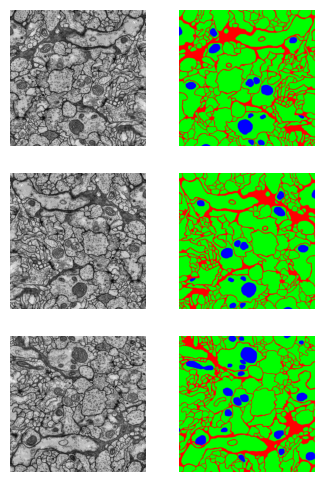

In [9]:
import matplotlib.pyplot as plt
from numpy import squeeze, random


fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, k in enumerate(random.choice(np.linspace(0, 19, 20).astype(int), 3)):
    image, label = pipeline([raw_sources[k], label_sources[k]])
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

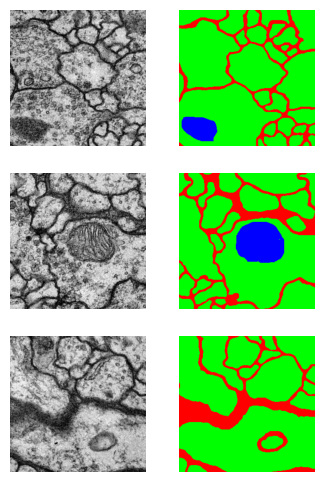

In [10]:
fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i, k in enumerate(random.choice(np.linspace(0, 19, 20).astype(int), 3)):
    image, label = ds[k]
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

In [1]:
import deeplay as dl
from torch.nn import Softmax2d, Identity, Sigmoid

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=3,
)
print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

In [ ]:
import torchmetrics as tm
from torch.nn import CrossEntropyLoss, L1Loss


regressor_template = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(),  # loss=L1Loss(),  #
    optimizer=dl.Adam(),
)

unet_regressor = regressor_template.create()

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(ds, batch_size=8, shuffle=True)

In [ ]:
unet_trainer = dl.Trainer(max_epochs=100, accelerator="auto")

unet_trainer.fit(unet_regressor, data_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | UNet2d           | 821 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
821 K     Trainable params
0         Non-trainable params
821 K     Total params
3.286     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | UNet2d           | 821 K 
5 | optimizer     | Adam             | 0     
---------------

Training: |          | 0/? [00:00<?, ?it/s]

In [18]:
image, label = pipeline([raw_sources[k], label_sources[k]])
pred = unet_regressor(image.unsqueeze(0)).detach().squeeze()

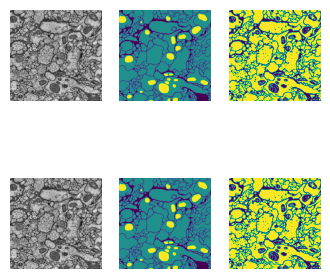

In [19]:
fig, axs = plt.subplots(2, 3, figsize=((4, 4)))
for i in range(2):
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0).numpy().argmax(axis=2))
    axs[i, 1].set_axis_off()
    axs[i, 2].imshow(pred.permute(1, 2, 0).numpy().argmax(axis=2))
    axs[i, 2].set_axis_off()

In [75]:
t = pred.permute(1, 2, 0).numpy().argmax(axis=2)

In [86]:
pred[0, 10, 10]

tensor(0.1691)

In [93]:
s = pred.permute(1, 2, 0).numpy()

In [94]:
s.shape

(1024, 1024, 3)

In [ ]:
from deeptrack.models import unet

In [ ]:
model = unet()
model.summary()